# Intro

## Background Problem

Earth is currently the only planet on which humans and other creatures live. Sadly, human activities worsen the Earth's condition over time through global warming. Scientists have been monitoring earth's condition through images that captured from artificial satellites.

## Objective

To help scientist classify images that captured from satellite, I will create a deep learning model that can automate that process. Thus, scientists can focused on another tasks that harder or more important.

- There are 4 classes of images that will be used to train the model, such as: dessert, green area, water, and cloudy.
- In this project, I will consider that all image classes are equally important, thus the metric I choose is accuracy.
- To create a robust model for prediction, minimum accuracy that the model must produce is 90%.

# Import Libs

In [1]:
import os
from os.path import join as path_join

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Dense, Input, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import DataFrameIterator

from sklearn.metrics import accuracy_score

import json

import warnings
warnings.filterwarnings("ignore")

# Data Loading

In [2]:
# define dir const
IMG_DIR_PATH = "/kaggle/input/data"

In [3]:
# define image class list
img_classes = [dirname for dirname in os.listdir(IMG_DIR_PATH)]
img_classes

['cloudy', 'desert', 'green_area', 'water']

In [4]:
# define image examples to plot
img_examples_dict = {}

for img_class in img_classes:
    img_file_path = []

    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class))[:5]:
        img_file_path.append(
            path_join(IMG_DIR_PATH, img_class, img_file_name)
        )
        
    img_examples_dict[img_class] = img_file_path

In [5]:
img_examples_dict

{'cloudy': ['/kaggle/input/data/cloudy/train_17406.jpg',
  '/kaggle/input/data/cloudy/train_28684.jpg',
  '/kaggle/input/data/cloudy/train_33597.jpg',
  '/kaggle/input/data/cloudy/train_34079.jpg',
  '/kaggle/input/data/cloudy/train_30586.jpg'],
 'desert': ['/kaggle/input/data/desert/desert(14).jpg',
  '/kaggle/input/data/desert/desert(217).jpg',
  '/kaggle/input/data/desert/desert(204).jpg',
  '/kaggle/input/data/desert/desert(1030).jpg',
  '/kaggle/input/data/desert/desert(1080).jpg'],
 'green_area': ['/kaggle/input/data/green_area/Forest_2838.jpg',
  '/kaggle/input/data/green_area/Forest_205.jpg',
  '/kaggle/input/data/green_area/Forest_2038.jpg',
  '/kaggle/input/data/green_area/Forest_344.jpg',
  '/kaggle/input/data/green_area/Forest_2181.jpg'],
 'water': ['/kaggle/input/data/water/SeaLake_926.jpg',
  '/kaggle/input/data/water/SeaLake_907.jpg',
  '/kaggle/input/data/water/SeaLake_844.jpg',
  '/kaggle/input/data/water/SeaLake_830.jpg',
  '/kaggle/input/data/water/SeaLake_2215.jpg']

In [6]:
def read_img_rgb(img_file_path: str)->np.array:
    """
    Return image using cv2 using rgb channel as 3-dimensional array
    
        param:
            img_file_path (str): image file path to load
            
        return:
            3-dimensional array that represent r,g,b color channel
    """

    # openCV read image use bgr channel as default
    # but matplotlib use rgb channel
    # thus, I read the image using openCV first, then convert the color channel into rgb
    img = cv2.imread(img_file_path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [7]:
def show_subplot_img(
    ncols: int, 
    figsize: tuple, 
    imgs_dict: dict, 
    nrows: int=1,
    cmap: str="viridis",
    is_plot_rgb: bool=False
)->None:
    """
    PLot images in :imgs_dict using subplots
    
        params:
            ncols (int): number of columns for subplot
            figsize (tuple): figure size of the subplot (w, h) in inches
            imgs_dict (dict): 
            nrows (int): number of rows for subplot [default=1]
            cmap (str): default colormap used in matplotlib
            is_plot_rgb (bool): whether plot image on each color channel (r, g, b) separately or plot as whole (rgb) [default=False]
    
        return: None
    """
    
    if(not is_plot_rgb):
        for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
            
            for j, img in enumerate(img_dict):
                axs[j].imshow(img, cmap)
                axs[j].title.set_text(f"image {j+1}")
                
            fig.suptitle(img_class)
            
        plt.show()

    else:
        rgb_label=["r", "g", "b"]

        for i, (img_class, img_dict) in enumerate(imgs_dict.items()):
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

            for j, img in enumerate(img_dict):
                axs[j].imshow(img, cmap)
                axs[j].title.set_text(f"channel {rgb_label[j]}")

            fig.suptitle(img_class)

        plt.show()

In [8]:
# I found out that images in dataset are having different size
# In this cell I do comprehensive analysis to find out 
# how many type of image sizes appear in the dataset

img_shape_64_64 = {}
img_shape_256_256 = {}
img_shape_else = []

for img_class in img_classes:
    img_64_64 = []
    img_256_256 = []
    for img_file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        img_read = read_img_rgb(path_join(IMG_DIR_PATH, img_class, img_file_name))
        if(img_read.shape==(64,64,3)):
            img_64_64.append(img_file_name)
        elif(img_read.shape==(256,256,3)):
            img_256_256.append(img_file_name)
        else:
            img_shape_else.append([img_read.shape, img_file_name])
    img_shape_64_64[img_class] = img_64_64
    img_shape_256_256[img_class] = img_256_256

print("image shape 64x64")
for k, v in img_shape_64_64.items():
    print(f"{k}: {len(v)}")

print("\nimage shape 256x256")
for k, v in img_shape_256_256.items():
    print(f"{k}: {len(v)}")

print("\nother shape: ", len(img_shape_else))

image shape 64x64
cloudy: 0
desert: 0
green_area: 1500
water: 1500

image shape 256x256
cloudy: 1500
desert: 1131
green_area: 0
water: 0

other shape:  0


In [10]:
# read 2 rgb images as examples

IMG_RGB_EXAMPLE1 = read_img_rgb(path_join(IMG_DIR_PATH, "green_area/Forest_344.jpg"))

IMG_RGB_EXAMPLE2 = read_img_rgb(path_join(IMG_DIR_PATH, "cloudy/train_33597.jpg"))

In [11]:
# print size of example images
print("ex img1 shape: ", IMG_RGB_EXAMPLE1.shape)
print("ex img2 shape: ", IMG_RGB_EXAMPLE2.shape)

ex img1 shape:  (64, 64, 3)
ex img2 shape:  (256, 256, 3)


- The in-depth analysis shows that the dataset contains 2 types of images in terms of size, such as 64x64x3 and 256x256x3.
- Since deep learning model requires images in the same size, thus I will use image size of 128x128x3 because it's a balanced choice that halves 256 and doubles 64

## EDA

In [12]:
# defined image shapes with and without channel
IMG_SHAPE = (128, 128)
IMG_SHAPE_WITH_CHANNEL = (128, 128, 3)

In [13]:
# read all images and store into dict
img_rgbs_dict={}
for k, img_file_paths in img_examples_dict.items():
    img_read = []
    
    for img_file_path in img_file_paths:
        img_read.append(read_img_rgb(img_file_path))
    img_rgbs_dict[k] = img_read

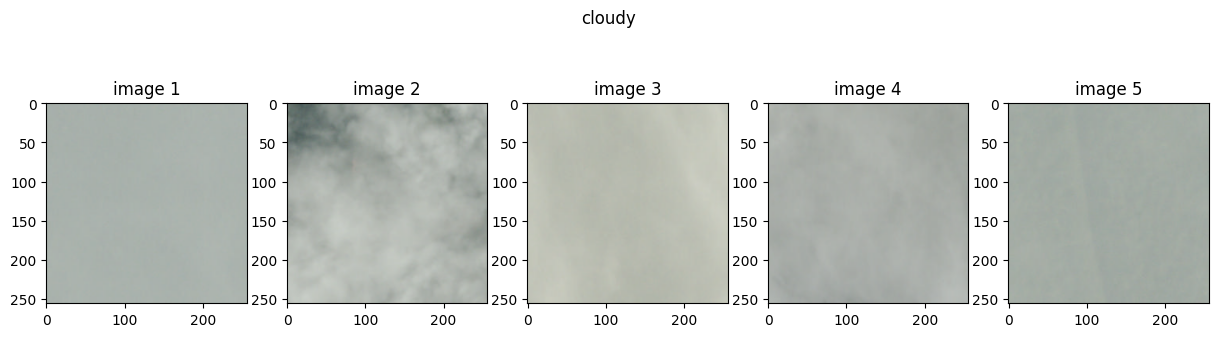

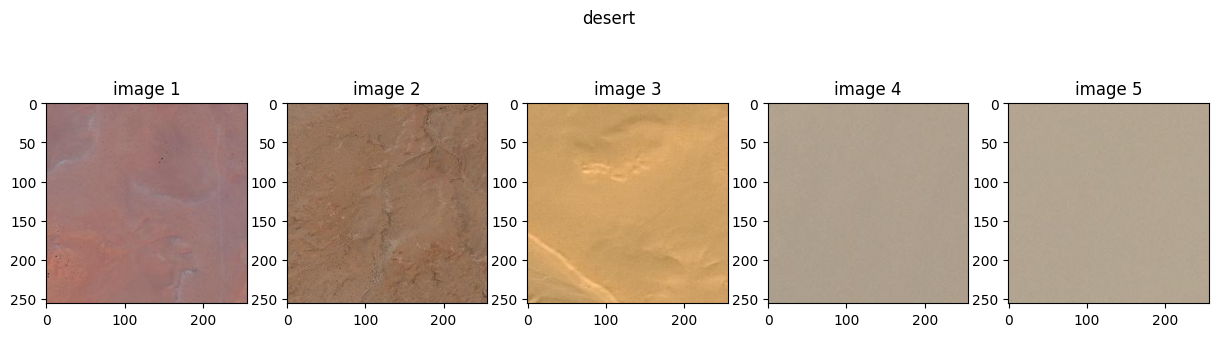

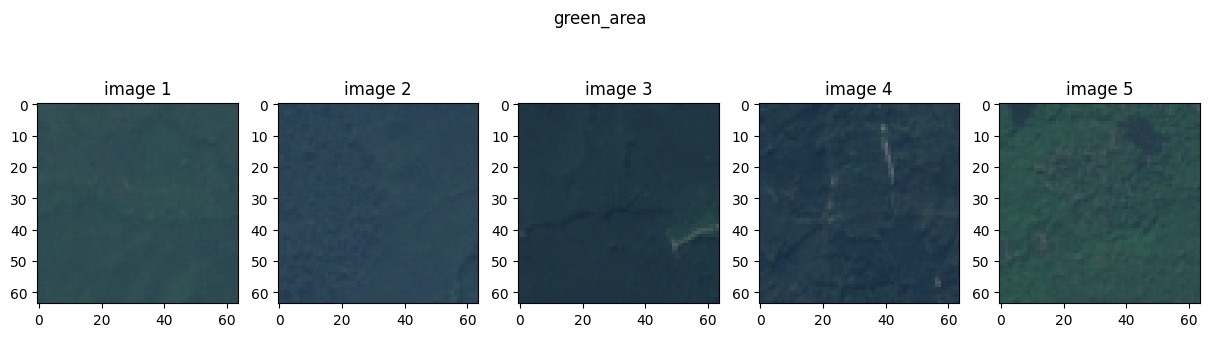

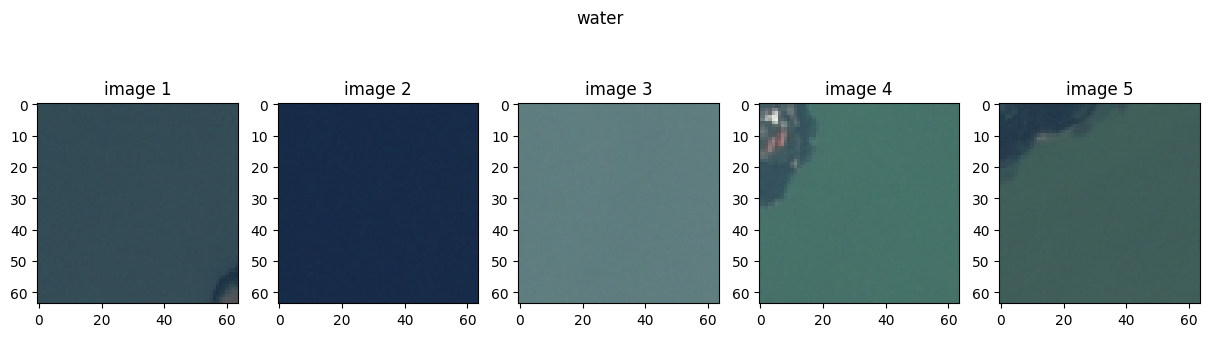

In [14]:
# plot 5 image for each class
show_subplot_img(5, (15, 4), img_rgbs_dict)

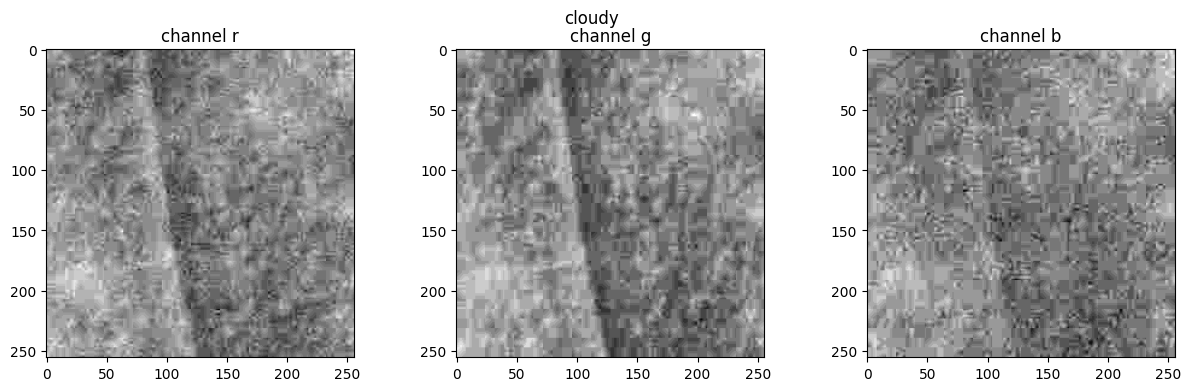

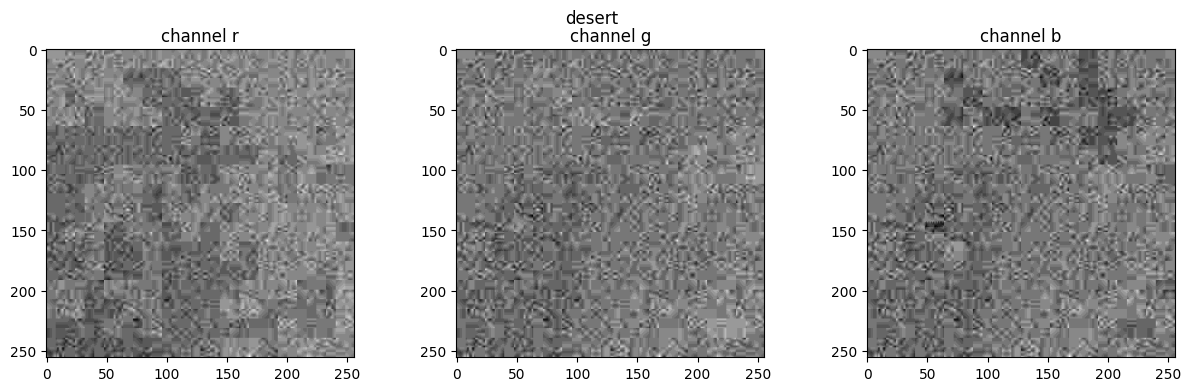

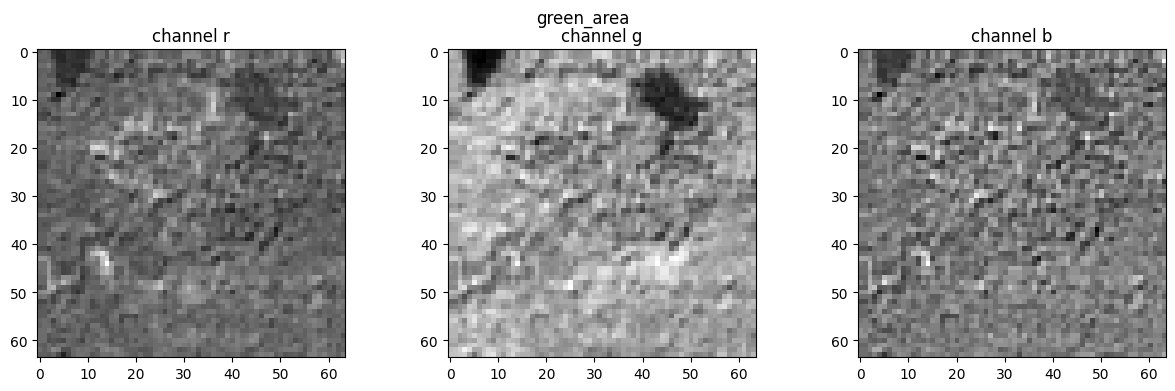

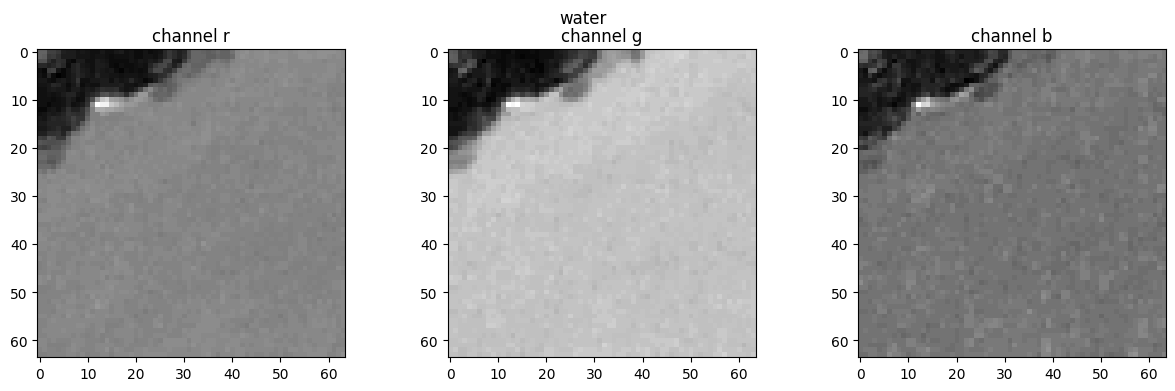

In [15]:
# plot rgb for each img class on 5th image
for img_class, img_rgbs in img_rgbs_dict.items():

    # split each color channel of an image
    r,g,b = cv2.split(img_rgbs[4])
    img_wrapper_dict = {img_class: [r,g,b]}
    
    show_subplot_img(3, (15, 4), img_wrapper_dict, cmap="gray", is_plot_rgb=True)

- The visualizations shown that charactheristics of images based on each color channel are simmilar.
- But, when it comes to colors, it's easier to differentiate these images
    - Cloudy area: gray
    - Dessert: somewhat brown
    - Green area: mixture of blue and green with contours that spread into all area
    - Water: mixture of blue and green that might contains objects

- Based on my analysis, these images can be distinguished by image's objects and colors. `Thus, I will use rbg image color to train the model`
- But, `I also will create a model that trained using grayscale color to prove my analysis`

# Feature Engineering

In this project, I will do some image augmentations to add variability on train and validation data, such as:
- Illumination or brightness
- Contrast

Hopefully these image augmentations will help the model to understand each class's characteristics better, thus increase the overall accuracy.

## Illuminate

In [16]:
# define matrix to adjust image's brightness
matrix_bright = np.ones(IMG_RGB_EXAMPLE2.shape, dtype="uint8") * 50

In [17]:
# brighten an image
img_rgb_brightened = cv2.add(
    IMG_RGB_EXAMPLE2,
    matrix_bright
)

# darken an image
img_rgb_darkened = cv2.subtract(
    IMG_RGB_EXAMPLE2, 
    matrix_bright
)

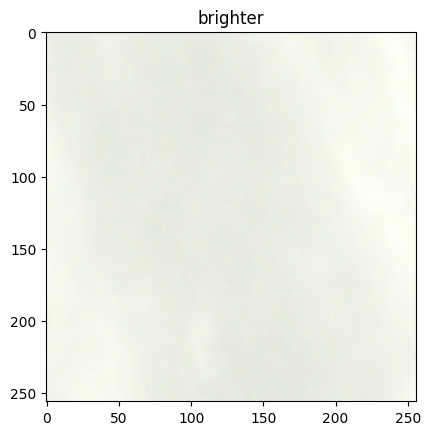

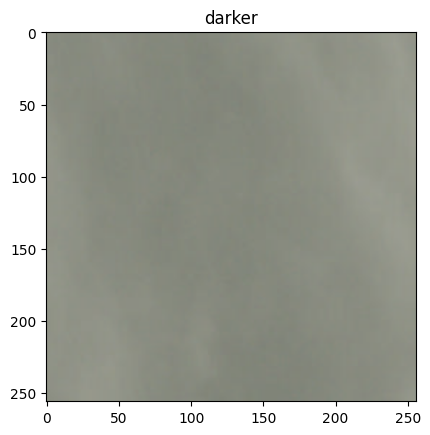

In [18]:
# plot adjusted brigthness image
plt.imshow(img_rgb_brightened)
plt.title("brighter")
plt.show()

plt.imshow(img_rgb_darkened)
plt.title("darker")
plt.show()

## Contrast

In [19]:
# define matrix for increasing and decreasing contrast
matrix_contrast_up = np.ones(IMG_RGB_EXAMPLE2.shape) * 1.6
matrix_contrast_down = np.ones(IMG_RGB_EXAMPLE2.shape) * 0.4

In [20]:
# adjust images' contrasts
img_rgb_cont_up   = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_up
    )
)

img_rgb_brightened_cont_up = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_brightened), 
        matrix_contrast_up)
    )

img_rgb_cont_down = np.uint8(
    cv2.multiply(
        np.float64(IMG_RGB_EXAMPLE2), 
        matrix_contrast_down
    )
)

img_rgb_darkened_cont_down = np.uint8(
    cv2.multiply(
        np.float64(img_rgb_darkened), 
        matrix_contrast_down
    )
)

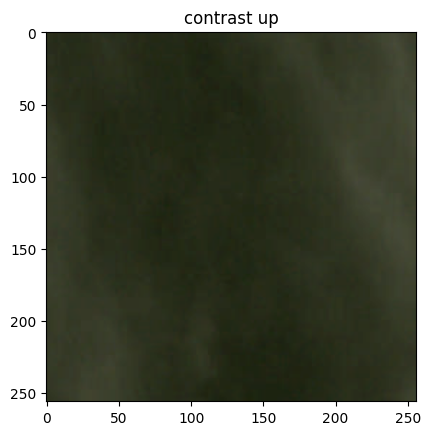

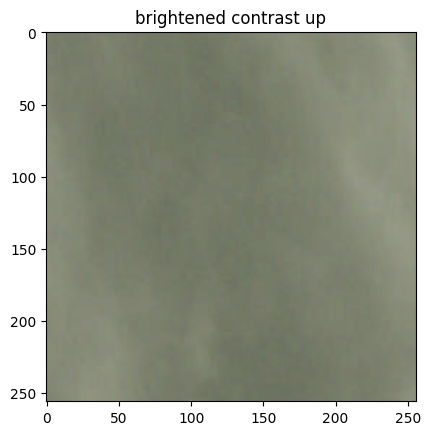

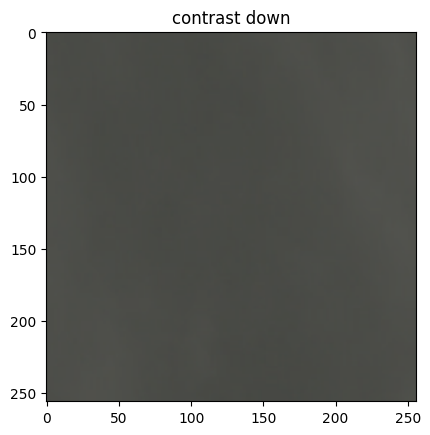

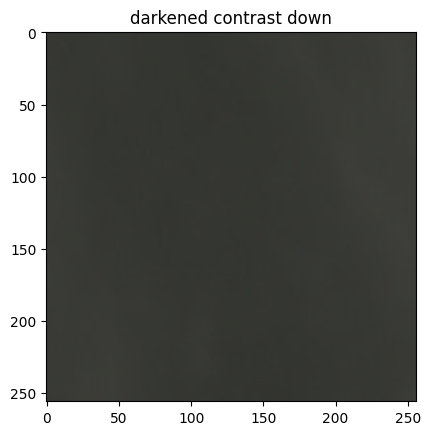

In [21]:
# plot adjusted contrast images
plt.imshow(img_rgb_cont_up)
plt.title("contrast up")
plt.show()

plt.imshow(img_rgb_brightened_cont_up)
plt.title("brightened contrast up")
plt.show()

plt.imshow(img_rgb_cont_down)
plt.title("contrast down")
plt.show()

plt.imshow(img_rgb_darkened_cont_down)
plt.title("darkened contrast down")
plt.show()

In [22]:
# provide list of labels and image paths to create dataframe
labels = [] 
paths = []

for img_class in img_classes:
    for file_name in os.listdir(path_join(IMG_DIR_PATH, img_class)):
        labels.append(img_class)
        paths.append(path_join(IMG_DIR_PATH, img_class, file_name))

In [23]:
print(labels[:5])
print(labels[-5:])

['cloudy', 'cloudy', 'cloudy', 'cloudy', 'cloudy']
['water', 'water', 'water', 'water', 'water']


In [24]:
print(paths[:5])
print(paths[-5:])

['/kaggle/input/data/cloudy/train_17406.jpg', '/kaggle/input/data/cloudy/train_28684.jpg', '/kaggle/input/data/cloudy/train_33597.jpg', '/kaggle/input/data/cloudy/train_34079.jpg', '/kaggle/input/data/cloudy/train_30586.jpg']
['/kaggle/input/data/water/SeaLake_682.jpg', '/kaggle/input/data/water/SeaLake_1614.jpg', '/kaggle/input/data/water/SeaLake_1184.jpg', '/kaggle/input/data/water/SeaLake_1427.jpg', '/kaggle/input/data/water/SeaLake_2146.jpg']


In [25]:
# create dataframe contains label and image path
img_df = pd.DataFrame(
    data={
        "label": labels,
        "path": paths
    }
)

img_df

,label,path
0,cloudy,/kaggle/input/data/cloudy/train_17406.jpg
1,cloudy,/kaggle/input/data/cloudy/train_28684.jpg
2,cloudy,/kaggle/input/data/cloudy/train_33597.jpg
3,cloudy,/kaggle/input/data/cloudy/train_34079.jpg
4,cloudy,/kaggle/input/data/cloudy/train_30586.jpg
...,...,...
5626,water,/kaggle/input/data/water/SeaLake_682.jpg
5627,water,/kaggle/input/data/water/SeaLake_1614.jpg
5628,water,/kaggle/input/data/water/SeaLake_1184.jpg
5629,water,/kaggle/input/data/water/SeaLake_1427.jpg


In [38]:
def get_index_sample_without_replace(
    df: pd.DataFrame, 
    sample_size: int
):
    """
    Get :sample_size number of indexes without replacement for sample data from :df
    
        parameters:
            df (pd.DataFrame): data source that contains label and path of each image
            
        return:
            index of samples as list
    """
    
    return list(
        df.sample(
            n=sample_size,
            replace=False,
            random_state=9
        ).index
    )

## Data Splitting

In [27]:
# define dict to contains number of samples of ecach image class
# used for test set
test_sizes_dict = {}

for img_class in img_df["label"].unique():
    # sample 0.1
    test_sizes_dict[img_class] = int(0.05 * img_df[img_df["label"]==img_class].shape[0])
    
test_sizes_dict

{'cloudy': 75, 'desert': 56, 'green_area': 75, 'water': 75}

In [28]:
# define list to contain index of images for the test set
test_data_idx = []
for img_class, sample_size in test_sizes_dict.items():
    test_data_idx+=get_index_sample_without_replace(
        img_df[img_df["label"]==img_class], 
        sample_size
    )

In [29]:
len(set(test_data_idx))

281

> All test data indexes are unique

In [30]:
# split dataset into 2: test & train-val
img_test_df = img_df.iloc[test_data_idx]
img_train_val_df = img_df.drop(index=test_data_idx)

In [31]:
img_train_val_df["label"].value_counts(normalize=True)

label
cloudy        0.266355
green_area    0.266355
water         0.266355
desert        0.200935
Name: proportion, dtype: float64

In [32]:
img_test_df["label"].value_counts(normalize=True)

label
cloudy        0.266904
green_area    0.266904
water         0.266904
desert        0.199288
Name: proportion, dtype: float64

In [33]:
# print shape, num of rows with missing and duplicated values
# on all image generators
for (label, df) in zip(
    ["img train-val", "img test"], 
    [img_train_val_df, img_test_df]
):
    print(label)
    print("shape: ", df.shape)
    print("number of rows with missing value: ", df.isna().sum().sum())
    print("number of rows with duplicated value: ", df.duplicated().sum(), end="\n\n")

img train-val
shape:  (5350, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0

img test
shape:  (281, 2)
number of rows with missing value:  0
number of rows with duplicated value:  0



## Image Generator

In this step I will add more variances on images for training and validation. This step will make sure that the model will learn wider range of image's characteristics.
The augmentation process including:
- horizontal & vertical flip
- zoom range 1 to 1,5
- rescale 1/255 -> rescaling to decrease the image's pixels while still retaining the same information, this can make the training process faster
- batch processing -> improve training speed and generalizability

In [34]:
# define parameters for img data generator
rescale = 1./255
horizontal_flip = vertical_flip = True
zoom_range = [1, 1.5]
batch_size=64

In [35]:
# create image data generator for train-val images
# I will use 15% of images for validation
train_val_img_datagen = ImageDataGenerator(
    validation_split=0.15,
    rescale=rescale,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip,
    zoom_range=zoom_range
)

In [36]:
# create image data generator for test images
test_img_datagen = ImageDataGenerator(rescale=rescale)

In [39]:
def get_adjusted_contrast_img(img: object) -> object:
    """
    Get adjusted contrast of :img using range contrast value from 0.4 to 1.6
    
        param:
            img (object): the image that needs contrast adjustment
    
        return:
            image with new contrast (object)
    """
    return tf.image.random_contrast(
        img, 
        lower=0.4, 
        upper=1.6, 
        seed=9
    )

### Grayscale

In [49]:
# split train-val images
img_train_gray = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    preprocessing_function=get_adjusted_contrast_img,
    color_mode="grayscale"
)

img_val_gray = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="validation",
    shuffle=True, 
    batch_size=batch_size,
    preprocessing_function=get_adjusted_contrast_img,
    color_mode="grayscale"
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.


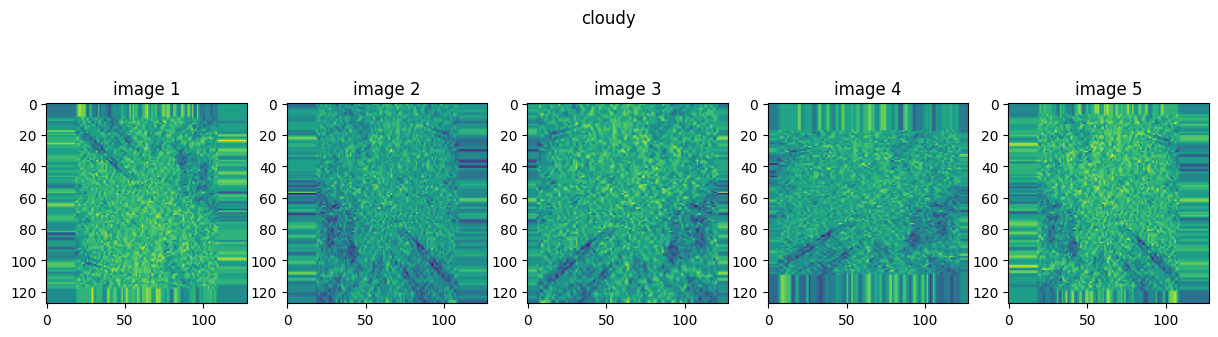

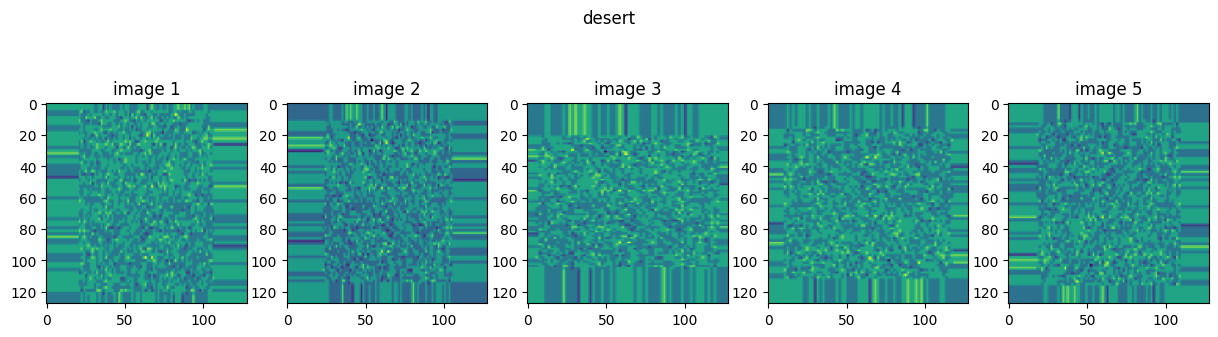

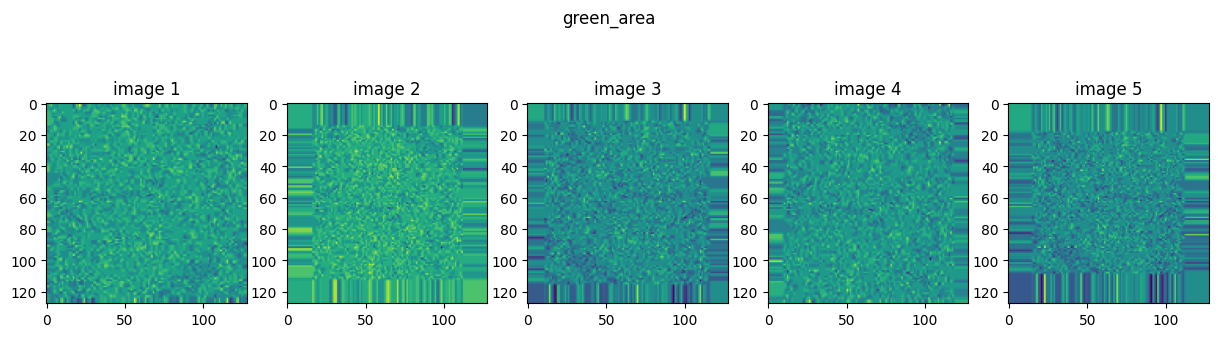

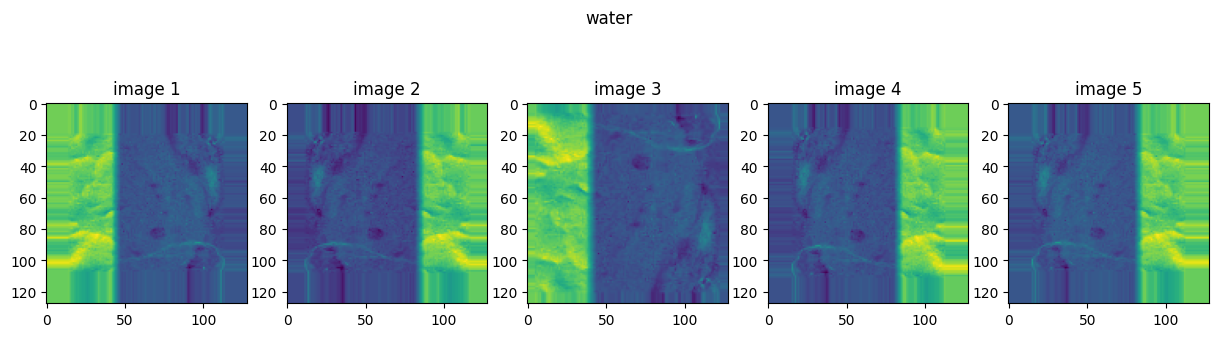

In [52]:
# plot some augmented grayscale images
img_gen_grayscales_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train_gray.class_indices):
    img_gen_grays = []
    for j in range(5):
        img_gen_grays.append(img_train_gray[0][0][img_pos])

    img_gen_grayscales_dict[batch_name] = img_gen_grays
    img_pos+=5
    
# plot 5 augmented grayscale images per class
show_subplot_img(5, (15, 4), img_gen_grayscales_dict)

In [56]:
img_test_gray = test_img_datagen.flow_from_dataframe(
    img_test_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9, 
    batch_size=batch_size,
    color_mode="grayscale",
    shuffle=False
)

Found 281 validated image filenames belonging to 4 classes.


### RGB

In [42]:
# split train-val images
img_train_rgb = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    preprocessing_function=get_adjusted_contrast_img,
    color_mode="rgb"
)

img_val_rgb = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="validation",
    shuffle=True, 
    batch_size=batch_size,
    preprocessing_function=get_adjusted_contrast_img,
    color_mode="rgb"
)

Found 4548 validated image filenames belonging to 4 classes.
Found 802 validated image filenames belonging to 4 classes.


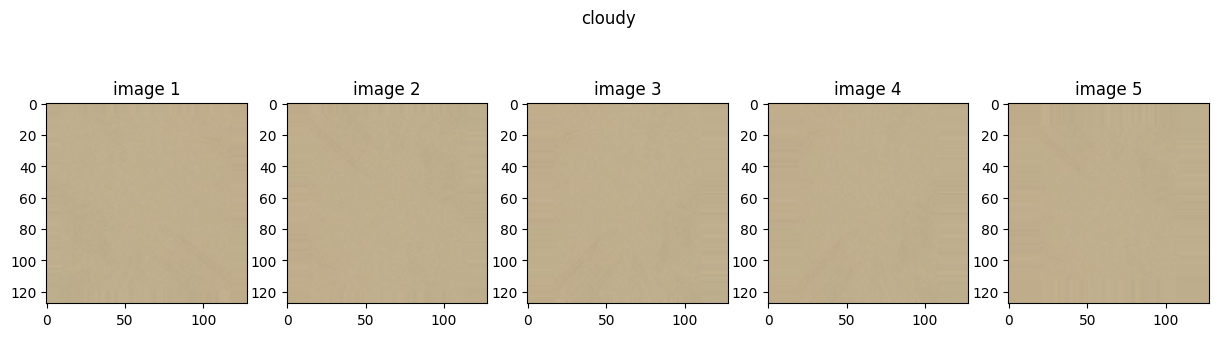

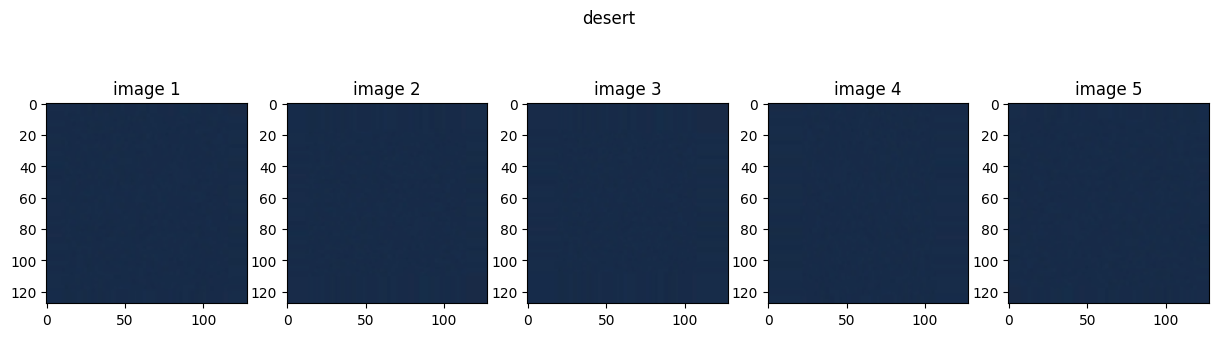

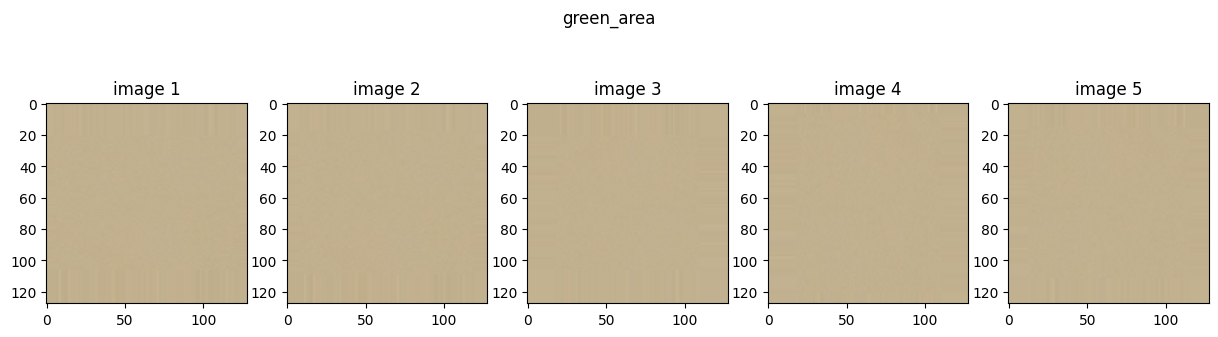

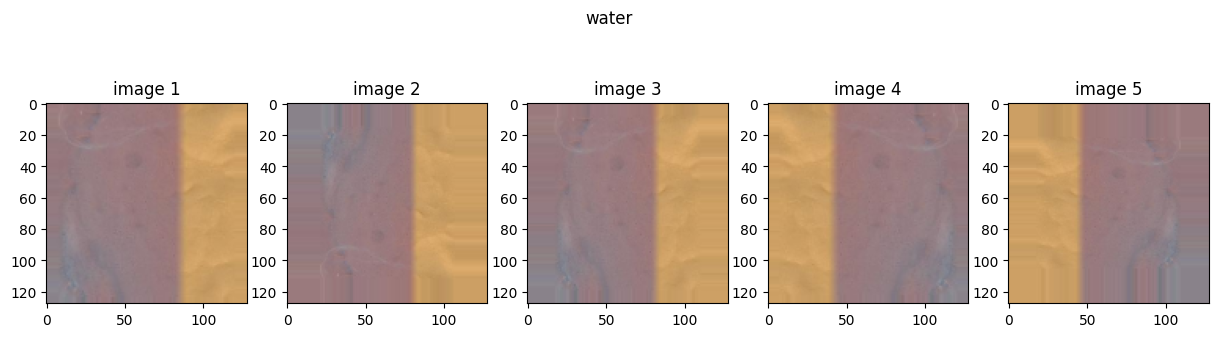

In [51]:
# plot some augmented rgb images
img_gen_rgbs_dict = {}
img_pos = 0
for i, batch_name in enumerate(img_train_rgb.class_indices):
    img_gen_rgbs = []
    for j in range(5):
        img_gen_rgbs.append(img_train_rgb[0][0][img_pos])

    img_gen_rgbs_dict[batch_name] = img_gen_rgbs
    img_pos+=5
    
# plot 5 augmented rgb images per class
show_subplot_img(5, (15, 4), img_gen_rgbs_dict)

In [53]:
img_test_rgb = test_img_datagen.flow_from_dataframe(
    img_test_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9, 
    batch_size=batch_size,
    color_mode="rgb",
    shuffle=False
)

Found 281 validated image filenames belonging to 4 classes.


> Number of images for training, validation, and test are 4,548; 802; and 281 respectively for both rgb and grayscale images

# Modelling

In [57]:
# define path const for saving model history
HIST_MODEL_DIR_PATH = path_join("/kaggle/working", "hist_model")
SAVED_HIST_MODEL_DIR_PATH = "/kaggle/input/model-history-images"

In [61]:
def get_model_history(
    model: object,
    loss_function: object,
    optimizer: object,
    metrics: list,
    train_data: DataFrameIterator,
    val_data: DataFrameIterator,
    epochs: int,
    callbacks: list=None
)->pd.DataFrame:
    """
    Get history of model training process as dataframe.

    This function process end-to-end training process in the following steps:
    1. compile
    2. fitting
    3. return the training history as dataframe
    
        params:
            model (object): model that hasn't been fitted
            loss_function (object): loss function used when compiling the model
            optimizer (object): optimezer function used when compiling the model
            metrics (list): list of evaluation metrics
            train_data (DataFrameIterator): data train from DataImageGenerator
            val_data (DataFrameIterator): data validation from DataImageGenerator
            epochs (int): number of epochs for model fitting process
            callbacks (list): list of callback functions to call in the model fitting process [default=None]

        return:
            trining history of the model (pd.DataFrame)
    """

    model.compile(
        loss=loss_function, 
        optimizer=optimizer, 
        metrics=metrics
    )

    history = model.fit(
        train_data, 
        epochs=epochs, 
        validation_data=val_data, 
        # print model's training progress
        verbose=1,
        callbacks=callbacks
    )

    return pd.DataFrame(history.history)

In [62]:
def create_dir_if_not_exists(dir_path: str)->None:
    """
    Create a new directory if it's not exist
    
        param:
            dir_path (str): path of the directory to create
    
        return: None
    """
    
    if(not os.path.exists(dir_path)):
        os.makedirs(dir_path)

In [ ]:
def plot_model_history(df: pd.DataFrame, model_name: str)->None:
    """
    Plot model training history to show accuracy and loss

        param:
            df (pd.DataFrame) -> data source that contains accuracy and loss on train and val sets

        return: None
    """

    # plot accuracy on train and val set
    df[["accuracy", "val_accuracy"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy on Train and Val set")
    plt.show()
    
    # plot loss on train and val set
    df[["loss", "val_loss"]].plot()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss on Train and Val set")
    plt.show()

In [ ]:
# def save_model_history_df(df: pd.DataFrame, model_name: str)->None:
#     """
#     Save model's training history as df
    
#     :param df (pd.DataFrame) -> model's training history to save
#     ;param model_name (str) -> model's name
    
#     :return None
#     """
    
#     MODEL_DIR_PATH = path_join(HIST_MODEL_DIR_PATH, model_name)
    
#     create_dir_if_not_exists(MODEL_DIR_PATH)
    
#     df.to_csv(
#         path_join(MODEL_DIR_PATH, f"{model_name}-train_hist.csv"), 
#         index=False
#     )



# def load_model_history_df(hist_file_path: str)->pd.DataFrame:
#     """
#     Load model's training history as df from :hist_file_path
    
#     ;param hist_file_path (str) -> file path of model's history dataframe
    
#     :return pd.DataFrame -> model's training history
#     """
    
#     return pd.read_csv(hist_file_path)

In [ ]:
def save_model_evaluation(model: object, test_data: DataFrameIterator)->None:
    """
    Show :model evaluation on unseen data (:test_data)
    
    :param model -> fitted model
    :param test_data -> data that contains image from image generator
    
    :return None
    """
    preds = model.predict(test_data)
    preds = np.argmax(preds, axis=1)
    
    MODEL_DIR_PATH = path_join(HIST_MODEL_DIR_PATH, model.name)
    
    create_dir_if_not_exists(MODEL_DIR_PATH)
    
    accuracy_res = accuracy_score(test_data.classes, preds)
    
    json.dump(
        accuracy_res,
        open(path_join(MODEL_DIR_PATH, f"{model.name}-accuracy.json"), "w")
    )
    

def load_model_evaluation(accuracy_score_file_path: str)->float:
    """
    Load model's evaluation score from :accuracy_score_file_path
    
    :param accuracy_score_file_path (str) -> path of model's accuracy file
    
    :return model's evaluation score (float)
    """
    
    return round(float(
            json.load(open(accuracy_score_file_path, "r"))
        ), 4)

## Model 1

### Training

For the first model, I will try this configurations:
- layers:
    - convolution2d
        - filter: 128
        - activation: relu
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
    - avg pooling 2d
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - padding: same -> mantaining pixel on each image's edges, since some images are having important object for differentiate image's characteristics on some edges
    - convolution 2d
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - filter: 258
        - activation: relu
    - flatten -> convert multidimensional data into one dimensional data, so it can be feeded to dense layer
    - dense
        - activation: relu
        - units: 512
    - dense (output)
        - activation: softmax -> for multi class classification
        - units: 4 -> to identify 4 classes
- optimizer: adam
- metrics: accuracy -> stated in objective
- epochs: 30 -> try high epoch to get the best result, since I implemented early stopping
- callback: early stopping
    - patience: 10 -> high patience so that the model won't miss global optima
    - monitor: val accuracy
    - mode: max -> stop the training process if the accuracy on validation data hasn't increasing by 10 tries
- loss function: categorical crossentrophy -> for multi class classification

- The value of filter and units on convolution and dense layer are increasing to get better result on accuracy [reference](https://www.quora.com/How-does-increasing-filter-size-improve-the-accuracy-of-a-convolutional-neural-network-CNN#:~:text=Increasing%20the%20filter%20size%20in,make%20predictions%20about%20the%20data.)

# gray scale

In [ ]:
model1 = Sequential([
    Input((128, 128, 1)),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1")

model1.summary()

In [ ]:
# split train-val images
img_train = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    preprocessing_function=adjust_img_contrast,
    color_mode="rgb"
)

img_val = train_val_img_datagen.flow_from_dataframe(
    img_train_val_df,
    # datagen only need height & weight size
    target_size=IMG_SHAPE,
    class_mode="categorical",
    x_col="path",
    y_col="label",
    keep_aspect_ratio=True,
    seed=9,
    subset="validation",
    shuffle=True, 
    batch_size=batch_size,
    preprocessing_function=adjust_img_contrast,
    color_mode="rgb"
)

In [ ]:
%%time
history1 = get_model_history(
    model1,
    "categorical_crossentropy",
    tf.keras.optimizers.Adam(learning_rate=0.001),
    ["accuracy"],
    img_train_gray,
    img_val_gray,
    20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            patience=5,
            monitor='val_accuracy',
            mode="max"
        )
    ]
)

history1

In [ ]:
model1 = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=128,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        512,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model1")

model1.summary()

In [ ]:
# %%time
# history1 = get_model_history(
#     model1,
#     "categorical_crossentropy",
#     tf.keras.optimizers.Adam(learning_rate=0.001),
#     ["accuracy"],
#     img_train,
#     img_val,
#     30,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             patience=10,
#             monitor='val_accuracy',
#             mode="max"
#         )
#     ]
# )

# history1

In [ ]:
# save_model_history_df(history1, model1.name)

In [ ]:
# load model1's saved training history dataframe
plot_model_history(
    load_model_history_df(path_join(SAVED_HIST_MODEL_DIR_PATH, "model1-train_hist.csv")), 
    "model1"
)

In [ ]:
# read last row of model1's training history
pd.read_csv(path_join(SAVED_HIST_MODEL_DIR_PATH, "model1-train_hist.csv")).tail(1)

### Evaluation

In [ ]:
# save model1's accuracy score
# save_model_evaluation(model1, img_test)

In [ ]:
# load saved model1's accuracy score
load_model_evaluation(path_join(SAVED_HIST_MODEL_DIR_PATH, "model1-accuracy.json"))

- The first model was able to generate 91%, 92%, 87,5% accuracy on train, validation, and test data respectively, but accuracy on test set is 87,5%. 
- Thus, this model can be considered as good fit, since the difference of accuracy score on test and train data is +- 3,5%.
- But the training history plot shows that the model's accuracy and loss have many spikes, indicating that the model has an exploding gradient problem

## Model Tuned

### Training

The first model was able to generate good accuracy score 87,5%, thus in the tuned model I'll just increase the filter and units size on covolution and dense layer to generate even higher accuracy:
- layers:
    - convolution2d
        - filter: 256
        - activation: relu
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
    - avg pooling 2d
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - padding: same -> mantaining pixel on each image's edges, since some images are having important object for differentiate image's characteristics on some edges
    - convolution 2d
        - pool size: (2, 2) -> small pool size to maintain image's overall information
        - strides: (2, 2) ->  small stride size to maintain image's overall information
        - filter: 512
        - activation: relu
    - flatten -> convert multidimensional data into one dimensional data, so it can be feeded to dense layer
    - dense
        - activation: relu
        - units: 1024
    - dense (output)
        - activation: softmax -> for multi class classification
        - units: 4 -> to identify 4 classes
- optimizer: adam
- metrics: accuracy -> stated in objective
- epochs: 30 -> try high epoch to get the best result, since I implemented early stopping
- callback: early stopping
    - patience: 10 -> high patience so that the model won't miss global optima
    - monitor: val accuracy
    - mode: max -> stop the training process if the accuracy on validation data hasn't increasing by 10 tries
- loss function: categorical crossentrophy -> for multi class classification

- The value of filter and units on convolution and dense layer are increasing to get better result on accuracy [reference](https://www.quora.com/How-does-increasing-filter-size-improve-the-accuracy-of-a-convolutional-neural-network-CNN#:~:text=Increasing%20the%20filter%20size%20in,make%20predictions%20about%20the%20data.)

In [ ]:
model_tuned = Sequential([
    Input(IMG_SHAPE_WITH_CHANNEL),
    Conv2D(
        filters=256,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    AveragePooling2D(
        pool_size=(2, 2),
        padding="same"
    ),
    Conv2D(
        filters=512,
        kernel_size=(2, 2),
        activation="relu",
        strides=(2, 2)
    ),
    Flatten(),
    Dense(
        1024,
        activation="relu"
    ),
    Dense(
        4,
        activation="softmax"
    )
], name="model-tuned")

model_tuned.summary()

In [ ]:
# %%time
# history_model_tuned = get_model_history(
#     model_tuned,
#     "categorical_crossentropy",
#     tf.keras.optimizers.Adam(learning_rate=0.0001),
#     ["accuracy"],
#     img_train,
#     img_val,
#     30,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(
#             patience=10,
#             monitor='val_accuracy',
#             mode="max"
#         )
#     ]
# )

# history_model_tuned

In [ ]:
# save model_tuned's training history
# save_model_history_df(history_model_tuned, model_tuned.name)

In [ ]:
# load model_tuned's saved training history dataframe
plot_model_history(
    load_model_history_df(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned-train_hist.csv")),
    "model-tuned"
)

In [ ]:
pd.read_csv(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned-train_hist.csv")).tail(1)

### Evaluation

In [ ]:
# save_model_evaluation(model_tuned, img_test)

In [ ]:
# load saved model_tuned's accuracy score
load_model_evaluation(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned-accuracy.json"))

- The tuned model was able to generate 92%, 93%, and 90% accuracy on train, validation, and test data respectively.
- This model also good fit, since the difference of accuracy score on test and train data is +- 2%.
- The tuned model is an improved version of the first model because it generates higher accuracy on both the training and validation data. Additionally, this model also reduced the score difference between the training and test data, proving that it is more consistent and robust

- But this model still has exploding gradient problem

# Model misclassification analysis

In [ ]:
img_test_df["label"].value_counts()

In [ ]:
# load saved model
loaded_model = tf.keras.models.load_model(path_join(SAVED_HIST_MODEL_DIR_PATH, "model-tuned.keras"))

pred_res = loaded_model.predict(img_test)
pred_res = np.argmax(pred_res, axis=1)
pred_res

In [ ]:
# create a dataframe to contain true and pred label
img_test_analysis = pd.DataFrame()
img_test_analysis["true_label"] = img_test.classes
img_test_analysis["pred_label"] = pred_res

In [ ]:
img_test_analysis

In [ ]:
# filter miss-classified images
miss_pred_df = img_test_analysis[
    img_test_analysis["true_label"]!=img_test_analysis["pred_label"]
]
miss_pred_df

In [ ]:
img_test.class_indices

In [ ]:
# filter image that miss-classifed as cloudy
miss_classified_as_cloudy = miss_pred_df[miss_pred_df["pred_label"]==0]
miss_classified_as_cloudy

In [ ]:
# filter image that miss-classifed as cloudy
miss_classified_as_cloudy = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==0].index]
miss_classified_as_cloudy

In [ ]:
# plot image that miss-classifed as cloudy
for path in miss_classified_as_cloudy["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- It turns out that all the images that the model misclassified as cloudy are similar to actual cloudy images
- These images are all having greyish color, except for the first one

In [ ]:
# filter image that miss-classifed as desert
miss_classified_as_desert = miss_pred_df[miss_pred_df["pred_label"]==1]
miss_classified_as_desert

In [ ]:
# filter image that miss-classifed as desert
miss_classified_as_desert = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==1].index]
miss_classified_as_desert

In [ ]:
# plot image that miss-classifed as desert
for path in miss_classified_as_desert["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- All images that the model misclassified as desert are similar to actual desert images
- These images are all having brownish color

- This conclude that some cloudy and desert images in the dataset are having similar colors.
- It might be that there's not enough cloudy image that similar to desert and vice versa in the dataset, so the model is uncorrectly identify these images' characteristics

In [ ]:
# filter image that miss-classifed as green area
miss_classified_as_green_area = miss_pred_df[miss_pred_df["pred_label"]==2]
miss_classified_as_green_area

In [ ]:
# filter image that miss-classifed as green area
miss_classified_as_green_area = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==2].index]
miss_classified_as_green_area

In [ ]:
# plot image that miss-classifed as green area
for path in miss_classified_as_green_area["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- All images that the model misclassified as green area are having mixed green and blue colors

In [ ]:
# filter image that miss-classifed as water
miss_classified_as_water = miss_pred_df[miss_pred_df["pred_label"]==3]
miss_classified_as_water

In [ ]:
# filter image that miss-classifed as water
miss_classified_as_water = img_test_df.iloc[miss_pred_df[miss_pred_df["pred_label"]==3].index]
miss_classified_as_water

In [ ]:
# plot image that miss-classifed as water
for path in miss_classified_as_water["path"]:
    plt.imshow(
        convert_img_channel(
            read_img_bgr(path),
            cv2.COLOR_BGR2RGB
        )
    )
    plt.show()

- All images that the model misclassified as water are having mixed green and blue colors, except the first one

- This conclude that, some green area and water images in the dataset are having mixed green and blue color.
- This misclassification also occurred because there are not enough water images similar to green areas, and vice versa, in the dataset

# Conclusion

- Tuned model is the best model to be used in NASA's system since it produced 90% accuracy and meets the minimum accuracy requirement stated in objective
- 90% accuracy means that `out of 10 images for every classes(cloudy, green area, desert, and water), this model able to correctly classify 9 of them`

Further improvement:
- Despite this model able to meet the minimum requirement on accuracy score, the model's size is exceptionally. As stated in [this reference](https://www.linkedin.com/pulse/your-model-slow-vijay-raghavan-ph-d-m-b-a-/), larger model tends to inference slower.

- The model can be improved by decreasing the number of units in the dense layers and the filter size in the convolution layers respectively, this will make the model's size to decrease. But the model's accuracy on the training, validation, and test data must remain similar, if not the same.

- The model also has some pattern in terms of misclassifying images, such as:
    - some water images misclassified as green area, and vice versa
    - some cloudy images misclassified as desert, and vice versa
- To encounter this problem, the dataset must be improved by:
    - providing water images that similar to green area, and vice versa.
    - providing cloudy images that similar to desert, and vice versa.

# Save files

In [ ]:
# for layer in model1.layers:
#     layer.trainable = False

In [ ]:
# model_tuned.save(path_join(HIST_MODEL_DIR_PATH, "model-tuned", "model-tuned.keras"))

In [ ]:
img_train.class_indices

In [ ]:
# export class encoder mapping
# json.dump(
#     img_train.class_indices, 
#     open(
#         path_join("/kaggle/working/", "class_indices.json"),
#         "w"
#     )
# )